In [280]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import shuffle
# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy import stats
from gensim.summarization import keywords
import datetime
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import PoissonRegressor

In [2]:
feature = pd.read_csv("Data/data.csv", index_col = 0)
feature = feature.reset_index().drop(['index'], axis = 1)

In [4]:
feature.head()

,link,title,text,view,topic,time,month,Innovation,Leadership,Lifestyle,...,num_keywords,kw_min_min,kw_min_max,kw_min_avg,kw_max_min,kw_max_max,kw_max_avg,kw_avg_min,kw_avg_max,kw_avg_avg
0,https://www.forbes.com/sites/billybambrough/20...,"$50 Billion Crash—What Next For Bitcoin, Ether...","Bitcoin, ethereum, Ripple\s XRP, bitcoin cash,...","47,503",Crypto & Blockchain,"Nov 27, 2020, 07:12am",Nov,0,0,0,...,316,33.0,47503.0,7025.750000,33.0,11524072.0,972514.750000,41.0,1859311.0,27658.245020
1,https://www.forbes.com/sites/abigailabesamis/2...,12 Bakers Share What They’re Whipping Up Durin...,Sourdough loaves (plus creative uses for disca...,"2,826",Dining,"May 22, 2020, 11:31am",May,0,0,1,...,1069,60.0,2826.0,964.800000,30.0,12490200.0,222607.118110,63.0,41856.0,5524.631579
2,https://www.forbes.com/sites/abigailabesamis/2...,15 Chefs Share What They’re Cooking During The...,In addition to offering delivery and curbside ...,"4,064",Dining,"Apr 16, 2020, 04:56pm",Apr,0,0,1,...,1137,137.0,4064.0,1397.833333,84.0,8418600.0,177826.712121,162.0,70403.0,7310.030303
3,https://www.forbes.com/sites/kyleedward/2020/1...,2021 Genesis GV80 First Drive: The Flagship SU...,Hyundai\s luxury brand Genesis has had a stron...,"4,264",Cars & Bikes,"Nov 26, 2020, 07:03pm",Nov,0,0,1,...,455,738.0,4264.0,1983.333333,30.0,12490200.0,105478.694805,2926.0,19966.0,8524.333333
4,https://www.forbes.com/sites/jasonfogelson/202...,2021 Genesis GV80 Test Drive And Review: Serio...,Meet the 2021 Genesis GV80.The US automotive m...,738,Cars & Bikes,"Nov 29, 2020, 03:05pm",Nov,0,0,1,...,815,738.0,738.0,738.000000,738.0,1859311.0,304880.250000,24.0,551511.0,11766.080460


### The following two cells are for preprocessing. The function takes in a list of column names that will be dropped. The function gets rid of December, filter outlier and re set index in the end

In [384]:
def pre_process(lst):
    data = feature.drop(lst, axis = 1)
    data['view'] = pd.Series([int(v.replace(",", "").replace(" ", "").replace(".", "")) for v in data['view']])
    data = data[data['Dec'] == 0]
    data = data.drop(['Dec'], axis = 1)
    data.drop(data[data['view'] > 250000].index, inplace = True) 
    data.drop(data[data['view'] < 200].index, inplace = True)
    data = data.reset_index().drop(['index'], axis = 1)
    return data

In [385]:
# data = feature.drop(['link', 'title', 'text', 'Unnamed: 0.1'], axis = 1)
data = pre_process(['link', 'title', 'text', 'topic', 'time', 'month', 'weekend_or_weekday'])
train = pre_process(['link', 'title', 'text', 'time', 'topic', 'weekend_or_weekday'])
EDA = pre_process([])

In [6]:
data.head()

,view,Innovation,Leadership,Lifestyle,Money,Apr,Aug,Feb,Jan,Jul,...,num_keywords,kw_min_min,kw_min_max,kw_min_avg,kw_max_min,kw_max_max,kw_max_avg,kw_avg_min,kw_avg_max,kw_avg_avg
0,47503,0,0,0,1,0,0,0,0,0,...,316,33.0,47503.0,7025.750000,33.0,11524072.0,972514.750000,41.0,1859311.0,27658.245020
1,2826,0,0,1,0,0,0,0,0,0,...,1069,60.0,2826.0,964.800000,30.0,12490200.0,222607.118110,63.0,41856.0,5524.631579
2,4064,0,0,1,0,1,0,0,0,0,...,1137,137.0,4064.0,1397.833333,84.0,8418600.0,177826.712121,162.0,70403.0,7310.030303
3,4264,0,0,1,0,0,0,0,0,0,...,455,738.0,4264.0,1983.333333,30.0,12490200.0,105478.694805,2926.0,19966.0,8524.333333
4,738,0,0,1,0,0,0,0,0,0,...,815,738.0,738.0,738.000000,738.0,1859311.0,304880.250000,24.0,551511.0,11766.080460


# EDA

In [369]:
data['view'].describe()

count    6.855000e+03
mean     3.776093e+04
std      3.741388e+05
min      2.000000e+02
25%      1.227500e+03
50%      3.563000e+03
75%      1.271200e+04
max      1.801222e+07
Name: view, dtype: float64

Text(0.5, 1.0, 'Distribution of views')

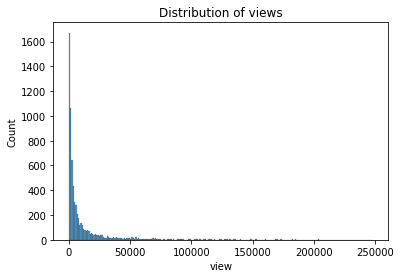

In [30]:
sns.histplot(data['view']).set_title("Distribution of views")

Text(0.5, 1.0, 'Boxplot of Views')

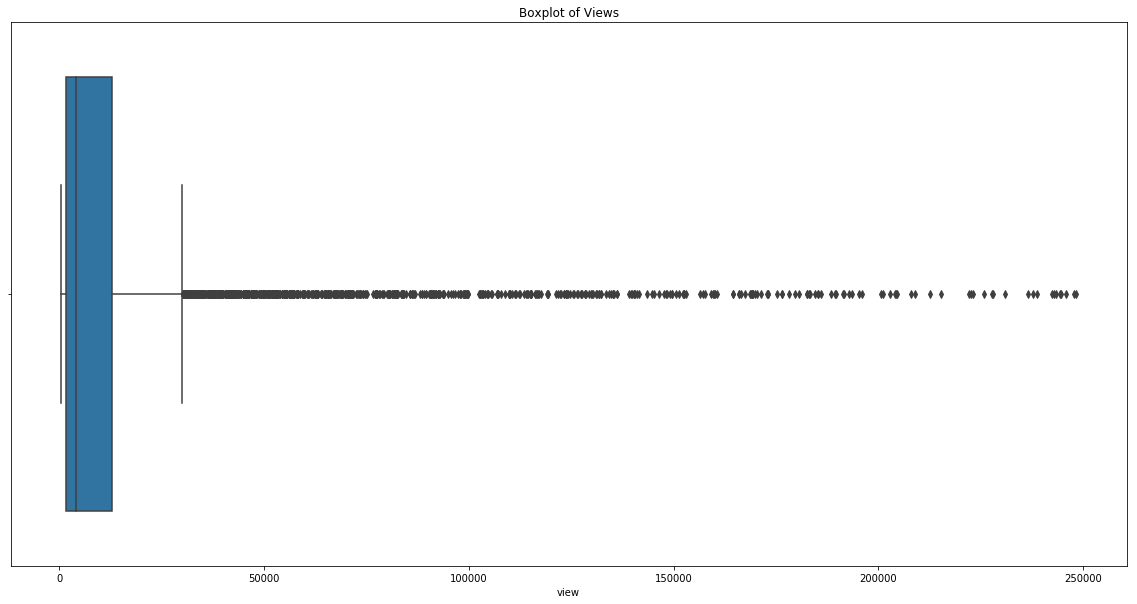

In [46]:
plt.figure(figsize = (20, 10))
sns.boxplot(x=data['view']).set_title("Boxplot of Views")

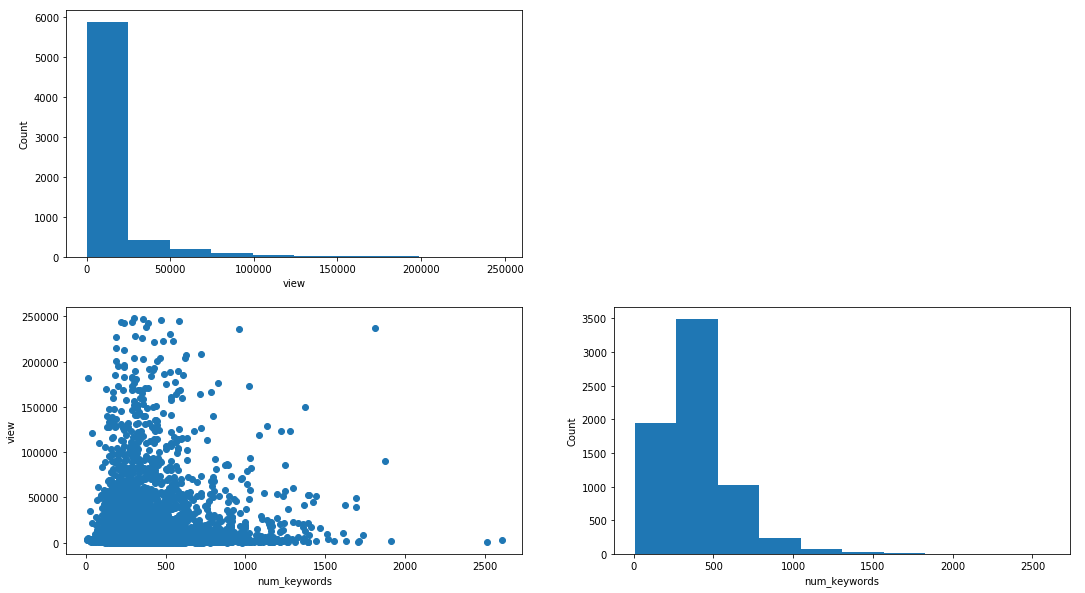

In [7]:
features = ['view', 'num_keywords']
scatterplotmatrix(data[features].values, names=features, figsize=(18,10), alpha=1);

In [391]:
innovation = ["Tech", "Enterprise & Cloud", "Big Data", "Healthcare, Healthcare", "Cloud", "AI", "Amazon Web Services BrandVoice | Paid Program",
                  "AWS Infrastructure Solutions BrandVoice | Paid Program", "Big Data,Cloud","Cloud 100",
                  "Consumer Tech","Cybersecurity","Enterprise Tech","Games","Green Tech","Healthcare",
                  "Innovation Rules","Japan BrandVoice | Paid Program","Jumio BrandVoice | Paid Program",
                  "SAP BrandVoice | Paid Program","Science","ServiceNow BrandVoice | Paid Program","Social Media",
                  "Tableau BrandVoice | Paid Program","T-Mobile For Business BrandVoice | Paid Program",
                  "Venture Capital"]
leadership = ["ForbesWomen, ForbesWomen", "Billionaires", "Asia", "World's Billionaires", "Forbes 400","America's Richest", "Self-Made Women", "China's Richest", 
                  "India's Richest","Indonesia's Richest","Korea's Richest","Thailand's Richest","Japan's Richest",
                  "Australia'sc Richest","Taiwan's Richest","Singapore's Richest","Philippines' Richest", 
                  "Hong Kong's Richest", "Malaysia's Richest", "Money & Politics", "2020 Money", "Careers","CEO Network","CFO Network","CIO Network","CMO Network",
                  "Deloitte BrandVoice | Paid Program","Diversity & Inclusion","Education","Forbes The Culture",
                  "ForbesWomen","Google Cloud BrandVoice | Paid Program","Leadership Strategy","Under 30",
                  "Working Remote"]
money = ["Hedge Funds & Private Equity", "Fintech", "Banking & Insurance","Crypto & Blockchain","ETFs & Mutual Funds","Fintech""Hedge Funds & Private Equity",
         "Investing","Markets","New York Life Investments BrandVoice | Paid Program","Personal Finance",
         "Premium Investing Newsletters","Retirement","Taxes","Tax-Smart Investing","Top Advisor | SHOOK",
         "Wealth Management","Election 2020", "Newsletters"]
business = ["Consumer", "Business, Business", "Small Business", "Aerospace & Defense","Energy","Hollywood & Entertainment",
            "Honeywell BrandVoice | Paid Program","Manufacturing","Media",
            "Mitsubishi Heavy Industries BrandVoice | Paid Program","Policy","Real Estate","Retail",
            "Salesforce BrandVoice | Paid Program","SportsMoney","Transportation", "Business As (Un)usual","Entrepreneurs","Franchises","Small Business Strategy","Square BrandVoice | Paid Program"]
lifestyle = ["Dining & Drinking", "Food & Drink", "Watches & Jewelry", "Arts","Boats & Planes","Cars & Bikes","Dining","ForbesLife","Forbes Travel Guide","Spirits",
             "Style & Beauty","Travel","Vices","Watches"]
EDA['topic'] = EDA['topic'].replace(innovation, "Innovation")
EDA['topic'] = EDA['topic'].replace(leadership, "Leadership")
EDA['topic'] = EDA['topic'].replace(money, "Money")
EDA['topic'] = EDA['topic'].replace(business, "Business")
EDA['topic'] = EDA['topic'].replace(lifestyle, "Lifestyle")

c:\users\zhang\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Total Views by Month')

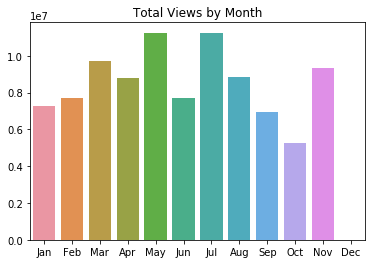

In [392]:
mon_lst = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data_lst = []
for i in mon_lst:
    month = EDA[EDA.month.isin([i])]
    month_views = np.sum(month.view)
    data_lst.append(month_views)
sns.barplot(mon_lst, data_lst).set_title("Total Views by Month")

c:\users\zhang\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Articles by Month')

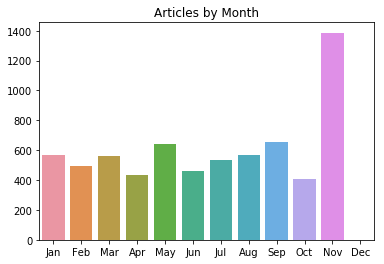

In [393]:
mon_lst = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data_lst = []
for i in mon_lst:
    month = EDA[EDA.month.isin([i])]
    month_counts = np.sum(month.shape[0])
    data_lst.append(month_counts)
sns.barplot(mon_lst, data_lst).set_title("Articles by Month")

c:\users\zhang\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Articles by Topic')

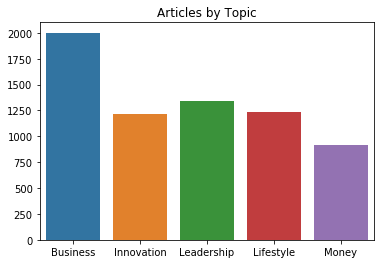

In [394]:
topic_lst = ['Business', 'Innovation', 'Leadership', 'Lifestyle', 'Money']
data_lst = []
for i in topic_lst:
    topic = EDA[EDA.topic.isin([i])]
    topic_counts = np.sum(topic.shape[0])
    data_lst.append(topic_counts)
sns.barplot(topic_lst, data_lst).set_title("Articles by Topic")

c:\users\zhang\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

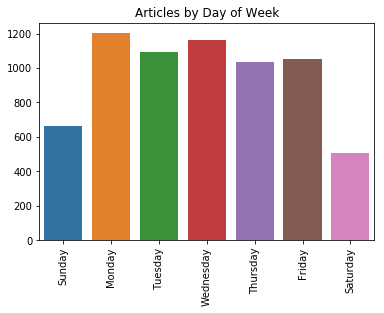

In [395]:
weekday_lst = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
data_lst = []
for i in weekday_lst:
    day = EDA[EDA.day_of_week.isin([i])]
    day_counts = np.sum(day.shape[0])
    data_lst.append(day_counts)
sns.barplot(['Sunday', 'Monday', 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday"], data_lst).set_title("Articles by Day of Week")
plt.xticks(rotation=90)

# Calculating variance

In [334]:
cor_pear = []
cor_ken = []
cor_spe = []
for i in data.columns:
    views = np.array([x for x in data['view']])
    cor, _ = stats.pearsonr(data[i], views)
    cor2, _ = stats.kendalltau(data[i], views)
    cor3, _ = stats.spearmanr(data[i], views)
    cor_pear.append(cor)
    cor_ken.append(cor2)
    cor_spe.append(cor3)
dic = {'pears_cor': cor_pear,
      'ken_cor': cor_ken,
      'spe_cor': cor_spe}
cor_tbl = pd.DataFrame(dic, data.columns)
pos_cor = cor_tbl[(cor_tbl['pears_cor'] > 0) & (cor_tbl['ken_cor'] > 0) & (cor_tbl['spe_cor'] > 0)].reset_index()

Text(0.5, 1.0, 'Correlations between Features and Shares')

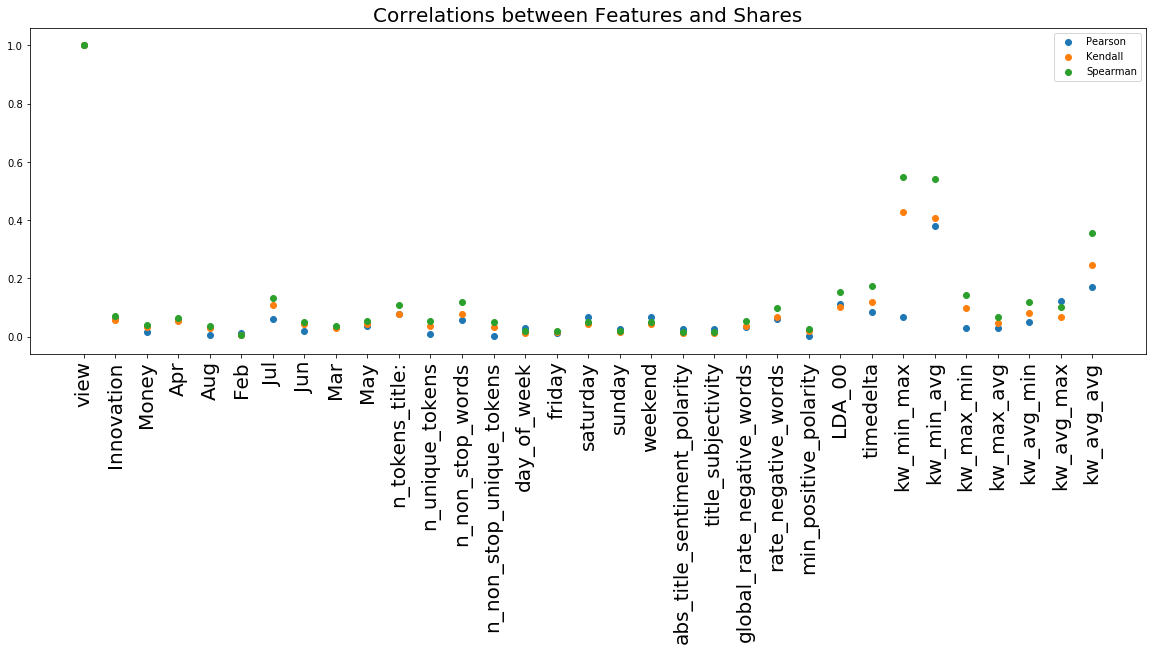

In [335]:
plt.figure(figsize=(20,6))
plt.scatter(pos_cor['index'],pos_cor['pears_cor'], label='Pearson')
plt.scatter(pos_cor['index'],pos_cor['ken_cor'], label='Kendall')
plt.scatter(pos_cor['index'],pos_cor['spe_cor'], label='Spearman')
plt.xticks(rotation=90, fontsize = 20)
plt.legend()
plt.title("Correlations between Features and Shares", fontsize=20)

# An OLS demo on Jan, Feb, Mar, Apr window

In [389]:
# mobility
train_months = ['Jan', 'Feb', 'Mar']
# variable_list = ['LDA_00', 'n_tokens_title:', 'rate_negative_words','kw_min_avg','kw_avg_max', 'kw_avg_avg']
variable_list = list(pos_cor['index'])[1:]
train_data = train[train.month.isin(train_months)]
train_label = train_data.view
# train_data = train_data.drop(['month', 'view'], axis = 1)
train_data = train_data[variable_list]

test_data = train[train.month.isin(['Apr'])]
test_label = test_data.view
# test_data = test_data.drop(['month', 'view'], axis = 1)
test_data = test_data[variable_list]


model = sm.OLS(train_label, train_data).fit() 
print(model.summary())

y_hat = model.predict(test_data)
pred = pd.DataFrame(y_hat)



                                 OLS Regression Results                                
Dep. Variable:                   view   R-squared (uncentered):                   0.376
Model:                            OLS   Adj. R-squared (uncentered):              0.366
Method:                 Least Squares   F-statistic:                              37.00
Date:                Wed, 09 Dec 2020   Prob (F-statistic):                   3.93e-143
Time:                        23:54:38   Log-Likelihood:                         -18854.
No. Observations:                1623   AIC:                                  3.776e+04
Df Residuals:                    1597   BIC:                                  3.790e+04
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [344]:
pred['true_view'] = test_label
pred['predict_view'] = pred[0]
pred['pct_error'] = ((pred.predict_view - pred.true_view)/pred.true_view)*100
pred = pred.drop([0], axis = 1)

In [345]:
pred

,true_view,predict_view,pct_error
2,4064,2268.734393,-44.174843
22,3540,1361.347454,-61.543857
82,1645,-4532.256416,-375.517107
114,662,-4162.322176,-728.749573
148,1684,-707.909079,-142.037356
...,...,...,...
5694,512,17320.722842,3282.953680
5695,3152,14174.035234,349.683859
5697,3097,17563.426713,467.110969
5720,6817,33285.688613,388.274734


# Train OLS on rolling window

In [396]:
lst = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov']
# variable_list = ['LDA_00', 'n_tokens_title:', 'rate_negative_words','kw_min_avg','kw_avg_max', 'kw_avg_avg']
variable_list = list(pos_cor['index'])[1:]
result = pd.DataFrame({'Train_month': [], 'Test_month': [], 'Average_pct_error': []})

for i in range(len(lst) - 3):
    
    months = lst[i: i+3]
    train_data = train[train.month.isin(months)]
    train_label = train_data.view
    
    train_data = train_data.drop(['month', 'view'], axis = 1)
#     train_data = train_data[variable_list]
    
    test_data = train[train.month.isin([lst[i+3]])]
    test_label = test_data.view
    test_data = test_data.drop(['month', 'view'], axis = 1)
#     test_data = test_data[variable_list]

    model = sm.OLS(train_label, train_data).fit()
    
    y_hat = model.predict(test_data)
    pred = pd.DataFrame(y_hat)
    pred['true_view'] = test_label
    pred['predict_view'] = pred[0]
    pred['pct_error'] = ((pred.predict_view - pred.true_view)/pred.true_view)*100
    
    pct_error = np.mean(pred['pct_error'])
    row = [', '.join(months), lst[i+3], pct_error]
    result.loc[len(result)] = row
    

In [397]:
result

,Train_month,Test_month,Average_pct_error
0,"Jan, Feb, Mar",Apr,-4.078043e+07
1,"Feb, Mar, Apr",May,-2.512117e+08
2,"Mar, Apr, May",Jun,-2.077185e+08
3,"Apr, May, Jun",Jul,-1.620805e+08
4,"May, Jun, Jul",Aug,-2.158531e+08
5,"Jun, Jul, Aug",Sep,2.129441e+07
6,"Jul, Aug, Sep",Oct,-7.432516e+07
7,"Aug, Sep, Oct",Nov,-6.090499e+08


# The following two cells are for ridge model

In [285]:
train_months = ['Jan', 'Feb', 'Mar']
variable_list = ['LDA_00', 'n_tokens_title:', 'rate_negative_words','kw_min_avg','kw_avg_max', 'kw_avg_avg']
train_data = train[train.month.isin(train_months)]
train_label = train_data.view
# train_data = train_data.drop(['month', 'view'], axis = 1)
train_data = train_data[variable_list]

test_data = train[train.month.isin(['Apr'])]
test_label = test_data.view
# test_data = test_data.drop(['month', 'view'], axis = 1)
test_data = test_data[variable_list]


model = Ridge(alpha=1.0).fit(train_data, train_label) 
print(model.coef_)

[ 1.31326910e+03  5.12171198e+02  2.19846776e+04  3.29092530e+00
  8.23386252e-05 -1.66742483e-01]


In [286]:
y_hat = model.predict(test_data)
pred = pd.DataFrame(test_label)
pred['predict_view'] =  y_hat
pred['pct_error'] = ((pred.predict_view - pred.view)/pred.view)*100
pred

,view,predict_view,pct_error
2,4064,7488.090793,84.254203
22,3540,11165.285493,215.403545
82,1645,7408.464853,350.362605
114,662,1626.939274,145.761220
148,1684,5968.376975,254.416685
...,...,...,...
5694,512,13727.970650,2581.244268
5695,3152,11893.077761,277.318457
5697,3097,20906.743453,575.064367
5720,6817,34880.783643,411.673517


# The following two cells are for RANSAC

In [287]:
train_months = ['Jan', 'Feb', 'Mar']
# variable_list = list(pos_cor['index'])[1:]
variable_list = ['LDA_00', 'n_tokens_title:', 'rate_negative_words','kw_min_avg','kw_avg_max', 'kw_avg_avg']
train_data = train[train.month.isin(train_months)]
train_label = train_data.view
# train_data = train_data.drop(['month', 'view'], axis = 1)
train_data = train_data[variable_list]

test_data = train[train.month.isin(['Apr'])]
test_label = test_data.view
# test_data = test_data.drop(['month', 'view'], axis = 1)
test_data = test_data[variable_list]


model = RANSACRegressor(random_state=1).fit(train_data, train_label)

In [288]:
model.score(train_data, train_label)

-0.030875757531353853

In [291]:
y_hat = model.predict(test_data)
pred = pd.DataFrame(test_label)
pred['predict_view'] =  y_hat
pred['pct_error'] = ((pred.predict_view - pred.view)/pred.view)*100
pred

,view,predict_view,pct_error
2,4064,3566.553747,-12.240311
22,3540,4393.431788,24.108243
82,1645,2013.180583,22.381798
114,662,-1304.593132,-297.068449
148,1684,1699.216778,0.903609
...,...,...,...
5694,512,-735.160828,-243.586099
5695,3152,1266.868243,-59.807480
5697,3097,6319.645197,104.056997
5720,6817,13209.421860,93.771774


# The following is for comparison

In [388]:
lst = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov']
variable_list = ['LDA_00', 'n_tokens_title:', 'rate_negative_words','kw_min_avg','kw_avg_max', 'kw_avg_avg']
# + ['Jan', 'Sep', 'Oct', 'Nov']
result = pd.DataFrame({'Train_month': [], 'Test_month': [], 'Average_pct_error_OLS': [], 'Average_pct_error_Ridge': [], 'Average_pct_error_RANSAC': []})

for i in range(len(lst) - 6):
    
    months = lst[i: i+6]
    train_data = train[train.month.isin(months)]
    train_label = train_data.view
    
#     train_data = train_data.drop(['month', 'view'], axis = 1)
    train_data = train_data[variable_list]
    
    test_data = train[train.month.isin([lst[i+6]])]
    test_label = test_data.view
#     test_data = test_data.drop(['month', 'view'], axis = 1)
    test_data = test_data[variable_list]

    model1 = sm.OLS(train_label, train_data).fit()
    model2 = Ridge(alpha=10).fit(train_data, train_label)
    model3 = RANSACRegressor(random_state=1).fit(train_data, train_label)
    
    y_hat_1 = model1.predict(test_data)
    pred_1 = pd.DataFrame(test_label)
    pred_1['predict_view'] =  y_hat_1
    pred_1['pct_error'] = ((pred_1.predict_view - pred_1.view)/pred_1.view)*100
    
    y_hat_2 = model2.predict(test_data)
    pred_2 = pd.DataFrame(test_label)
    pred_2['predict_view'] =  y_hat_2
    pred_2['pct_error'] = ((pred_2.predict_view - pred_2.view)/pred_2.view)*100
    
    y_hat_3 = model3.predict(test_data)
    pred_3 = pd.DataFrame(test_label)
    pred_3['predict_view'] =  y_hat_3
    pred_3['pct_error'] = ((pred_3.predict_view - pred_3.view)/pred_3.view)*100
    
    pct_error_1 = np.mean(pred_1['pct_error'])
    pct_error_2 = np.mean(pred_2['pct_error'])
    pct_error_3 = np.mean(pred_3['pct_error'])
    row = [', '.join(months), lst[i+6], pct_error_1, pct_error_2, pct_error_3]
    result.loc[len(result)] = row
result

,Train_month,Test_month,Average_pct_error_OLS,Average_pct_error_Ridge,Average_pct_error_RANSAC
0,"Jan, Feb, Mar, Apr, May, Jun",Jul,357.296020,340.065529,12.765784
1,"Feb, Mar, Apr, May, Jun, Jul",Aug,409.791899,386.235687,14.712310
2,"Mar, Apr, May, Jun, Jul, Aug",Sep,666.568385,634.645327,89.812642
3,"Apr, May, Jun, Jul, Aug, Sep",Oct,523.779937,498.377277,47.477806
4,"May, Jun, Jul, Aug, Sep, Oct",Nov,765.292144,727.014411,94.771695


In [354]:
lst = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov']
# variable_list = ['LDA_00', 'n_tokens_title:', 'rate_negative_words','kw_min_avg','kw_avg_max', 'kw_avg_avg']
# + ['Jan', 'Sep', 'Oct', 'Nov']
variable_list = list(pos_cor['index'])[1:]
result = pd.DataFrame({'Train_month': [], 'Test_month': [], 'Average_pct_error_OLS': [], 'Average_pct_error_Ridge': [], 'Average_pct_error_RANSAC': []})

for i in range(len(lst) - 3):
    
    months = lst[i: i+3]
    train_data = train[train.month.isin(months)]
    train_label = train_data.view
    
#     train_data = train_data.drop(['month', 'view'], axis = 1)
    train_data = train_data[variable_list]
    
    test_data = train[train.month.isin([lst[i+3]])]
    test_label = test_data.view
#     test_data = test_data.drop(['month', 'view'], axis = 1)
    test_data = test_data[variable_list]

    model1 = sm.OLS(train_label, train_data).fit()
    model2 = Ridge(alpha=10).fit(train_data, train_label)
    model3 = RANSACRegressor(random_state=4).fit(train_data, train_label)
    
    y_hat_1 = model1.predict(test_data)
    pred_1 = pd.DataFrame(test_label)
    pred_1['predict_view'] =  abs(y_hat_1)
    pred_1['pct_error'] = ((pred_1.predict_view - pred_1.view)/pred_1.view)*100
    
    y_hat_2 = model2.predict(test_data)
    pred_2 = pd.DataFrame(test_label)
    pred_2['predict_view'] =  abs(y_hat_2)
    pred_2['pct_error'] = ((pred_2.predict_view - pred_2.view)/pred_2.view)*100
    
    y_hat_3 = model3.predict(test_data)
    pred_3 = pd.DataFrame(test_label)
    pred_3['predict_view'] =  abs(y_hat_3)
    pred_3['pct_error'] = ((pred_3.predict_view - pred_3.view)/pred_3.view)*100
    
    pct_error_1 = np.mean(pred_1['pct_error'])
    pct_error_2 = np.mean(pred_2['pct_error'])
    pct_error_3 = np.mean(pred_3['pct_error'])
    row = [', '.join(months), lst[i+3], pct_error_1, pct_error_2, pct_error_3]
    result.loc[len(result)] = row
result

,Train_month,Test_month,Average_pct_error_OLS,Average_pct_error_Ridge,Average_pct_error_RANSAC
0,"Jan, Feb, Mar",Apr,319.729076,356.004239,1392.898791
1,"Feb, Mar, Apr",May,401.005362,368.403006,398.307972
2,"Mar, Apr, May",Jun,1193.665884,298.099140,217.026743
3,"Apr, May, Jun",Jul,1125.715705,242.256164,396.768366
4,"May, Jun, Jul",Aug,1713.486585,347.450707,171.833617
5,"Jun, Jul, Aug",Sep,1587.295163,347.152479,107.398336
6,"Jul, Aug, Sep",Oct,167.605017,127.312918,1353.532792
7,"Aug, Sep, Oct",Nov,354.960497,305.893875,599.146119


In [386]:
lst = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov']
variable_list = ['LDA_00', 'n_tokens_title:', 'rate_negative_words','kw_min_avg','kw_avg_max', 'kw_avg_avg']
# + ['Jan', 'Sep', 'Oct', 'Nov']
result = pd.DataFrame({'Train_month': [], 'Test_month': [], 'Average_pct_error_OLS': [], 'Average_pct_error_Ridge': [], 'Average_pct_error_RANSAC': []})

for i in range(len(lst) - 3):
    
    months = lst[i: i+3]
    train_data = train[train.month.isin(months)]
    train_label = train_data.view
    
#     train_data = train_data.drop(['month', 'view'], axis = 1)
    train_data = train_data[variable_list]
    
    test_data = train[train.month.isin([lst[i+3]])]
    test_label = test_data.view
#     test_data = test_data.drop(['month', 'view'], axis = 1)
    test_data = test_data[variable_list]

    model1 = sm.OLS(train_label, train_data).fit()
    model2 = Ridge(alpha=1).fit(train_data, train_label)
    model3 = RANSACRegressor(random_state=4).fit(train_data, train_label)
    
    y_hat_1 = model1.predict(test_data)
    pred_1 = pd.DataFrame(test_label)
    pred_1['predict_view'] =  y_hat_1
    pred_1['pct_error'] = ((pred_1.predict_view - pred_1.view)/pred_1.view)*100
    
    y_hat_2 = model2.predict(test_data)
    pred_2 = pd.DataFrame(test_label)
    pred_2['predict_view'] =  y_hat_2
    pred_2['pct_error'] = ((pred_2.predict_view - pred_2.view)/pred_2.view)*100
    
    y_hat_3 = model3.predict(test_data)
    pred_3 = pd.DataFrame(test_label)
    pred_3['predict_view'] =  y_hat_3
    pred_3['pct_error'] = ((pred_3.predict_view - pred_3.view)/pred_3.view)*100
    
    pct_error_1 = np.mean(pred_1['pct_error'])
    pct_error_2 = np.mean(pred_2['pct_error'])
    pct_error_3 = np.mean(pred_3['pct_error'])
    row = [', '.join(months), lst[i+3], pct_error_1, pct_error_2, pct_error_3]
    result.loc[len(result)] = row
result

,Train_month,Test_month,Average_pct_error_OLS,Average_pct_error_Ridge,Average_pct_error_RANSAC
0,"Jan, Feb, Mar",Apr,477.185388,466.504964,62.594194
1,"Feb, Mar, Apr",May,487.871928,454.136389,163.364450
2,"Mar, Apr, May",Jun,461.134148,422.646195,20.804344
3,"Apr, May, Jun",Jul,374.704348,347.975590,31.416039
4,"May, Jun, Jul",Aug,439.161979,415.720109,183.568721
5,"Jun, Jul, Aug",Sep,696.576601,692.576029,246.302175
6,"Jul, Aug, Sep",Oct,500.632742,497.333328,66.804967
7,"Aug, Sep, Oct",Nov,515.204290,535.530223,134.833123
